# Projet réalisé par : EL MANSOURI Mohammed-Adnane et YESSARI Ayoub

## Introduction 

La segmentation des maladies cérébrales est principalement faite à la main, c'est une procédure qui demande beaucoup de temps et les variations intra et inter expert pour un même cas varient beaucoup. Pour répondre à ces problèmes, il existe beaucoup de méthodes automatique et semi-automatique qui ont été proposés ces dernières années pour aider les praticiens à prendre des décisions. Les méthodes basées sur l'apprentissage automatique ont suscité un fort intérêt dans le domaine de la segmentation des tumeurs cérébrales. L'avènement des méthodes de Deep Learning et leurs succès dans maintes applications tels que la classification d'images a contribué à mettre de l'avant le Deep Learning dans l'analyse d'images médicales. 

Ce notebook vise à utiliser les Convolutions 3D pour essayer d'obtenir le meilleur résultat possible pour une segmentation d'images cérébrales de rats. Ici, nous n'allons pas trop loin ou ne modifions pas trop la structure du modèle, nous voulons simplement établir un point de départ pour une version de base qui sera eventuellement améliorée.

## Modèle choisi

Le modèle choisi pour ce projet est 3D U-NET qui est documenté dans de nombreuses excellentes publications qui expliquent le modèle, la formation et l'utilisation. L'idée ici est simplement de rendre un modèle un peu plus compliqué que de simples convolutions. Pour ce faire, nous utilisons la connexion par saut de U-NET combinée au max pooling et au upsampling / déconvolution afin de tirer parti des différentes structures d'échelle. Le réseau utilisé ci-dessous n'a que 2 étapes de max pooling, la première en z, x et y et la seconde uniquement en x et y (car notre dimension z n'est souvent pas divisible par 4).




In [1]:
!pip install nibabel

You should consider upgrading via the 'pip install --upgrade pip' command.


## Chargement des données et exploration

In [2]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
from tqdm import tqdm

folder = './data/'

imgs, labels = [], []
for sub, directories, files in os.walk(folder):
    for file in tqdm(files):
        filename = os.path.join(sub, file)
        if filename.endswith(".nii") and not "nifti_em" in filename:
            if not ("-labels" in filename):
                imgs.append(nib.load(filename).get_fdata())
            else:
                labels.append(nib.load(filename).get_fdata())

print("DATA LOADED SUCCEFULLY !! ")

0it [00:00, ?it/s]
100%|██████████| 3/3 [00:00<00:00, 223.20it/s]

DATA LOADED SUCCEFULLY !! 


In [3]:
type(imgs)

list

In [4]:
for img in imgs:
    print(img.shape)

(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)


In [5]:
for label in labels:
    print(label.shape)

(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)


In [6]:
imgs = np.array(imgs, dtype=np.float32) 
labels = np.array(labels, dtype=np.int8)

In [7]:
print("Shape of our imgs: ", imgs.shape)
print("Shape of our labels: ", labels.shape)

Shape of our imgs:  (16, 128, 128, 128)
Shape of our labels:  (16, 128, 128, 128)


In [8]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
from sklearn.model_selection import train_test_split
from skimage.util import montage2d
from warnings import warn

16


Text(0.5, 1.0, 'Mask')

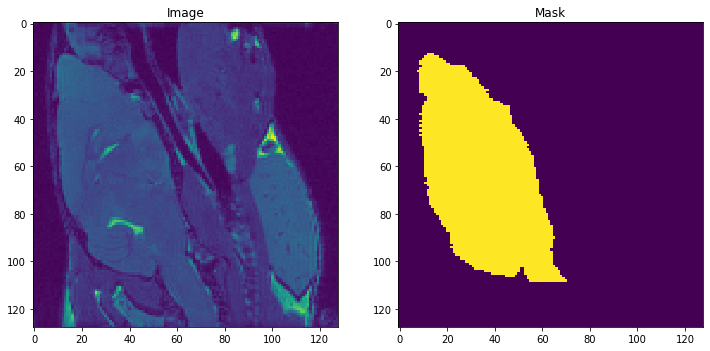

In [9]:
import matplotlib.pyplot as plt

print(len(labels))

test_image=imgs[3]
test_mask=labels[3]
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.imshow(test_image[int(test_image.shape[0]/2)])
ax1.set_title('Image')
ax2.imshow(test_mask[int(test_mask.shape[0]/2)])
ax2.set_title('Mask')

You should consider upgrading via the 'pip install --upgrade pip' command.
AxesImage(180,180;1116x1087.2)


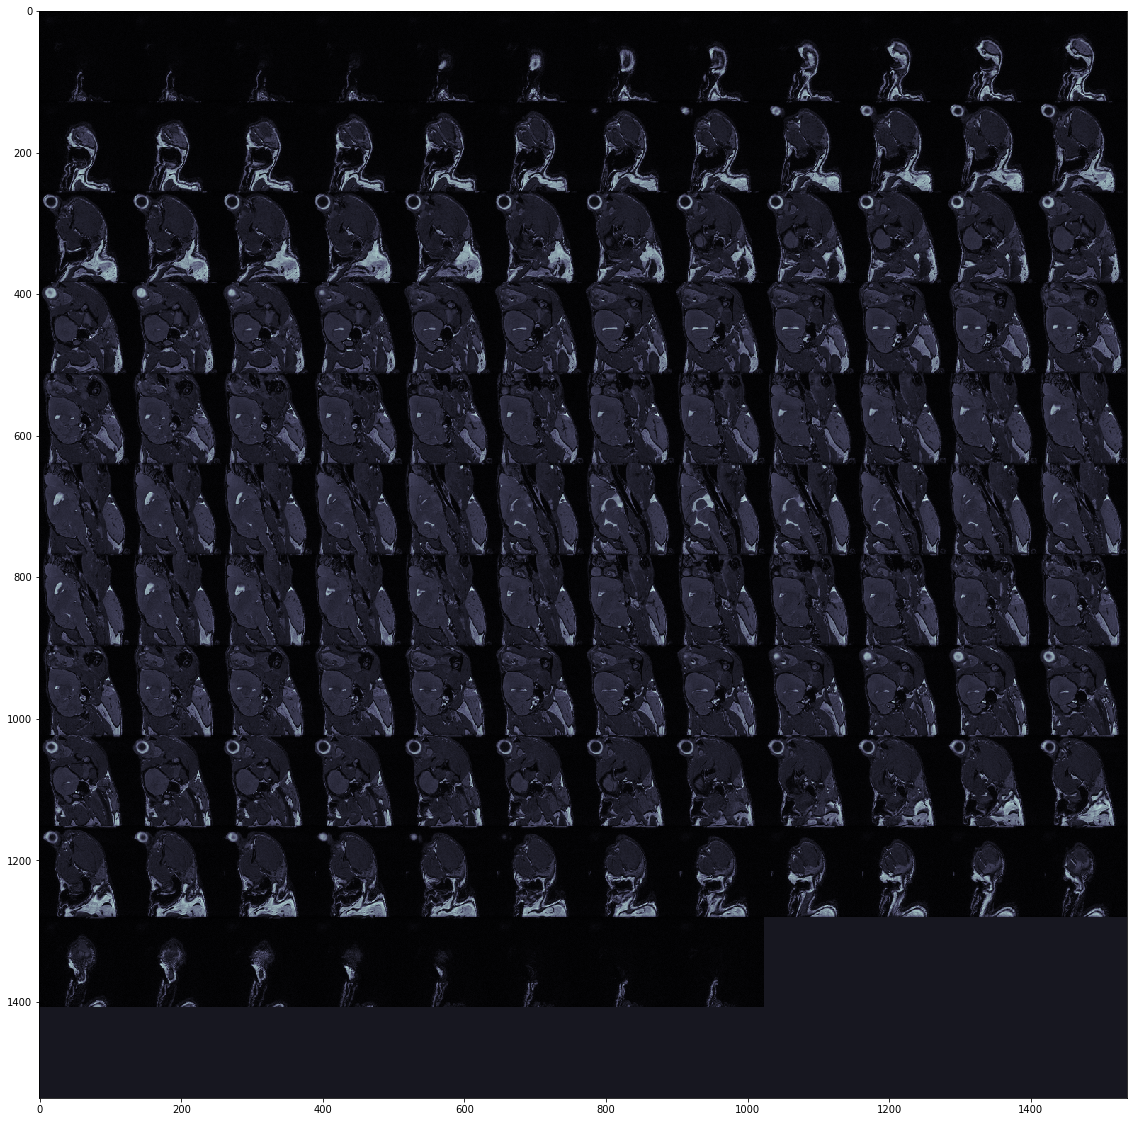

In [10]:
!pip install scikit-image==0.14.2

from skimage.util import montage
fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
print(ax1.imshow(montage(test_image), cmap ='bone'))
fig.savefig('ct_scan.png')

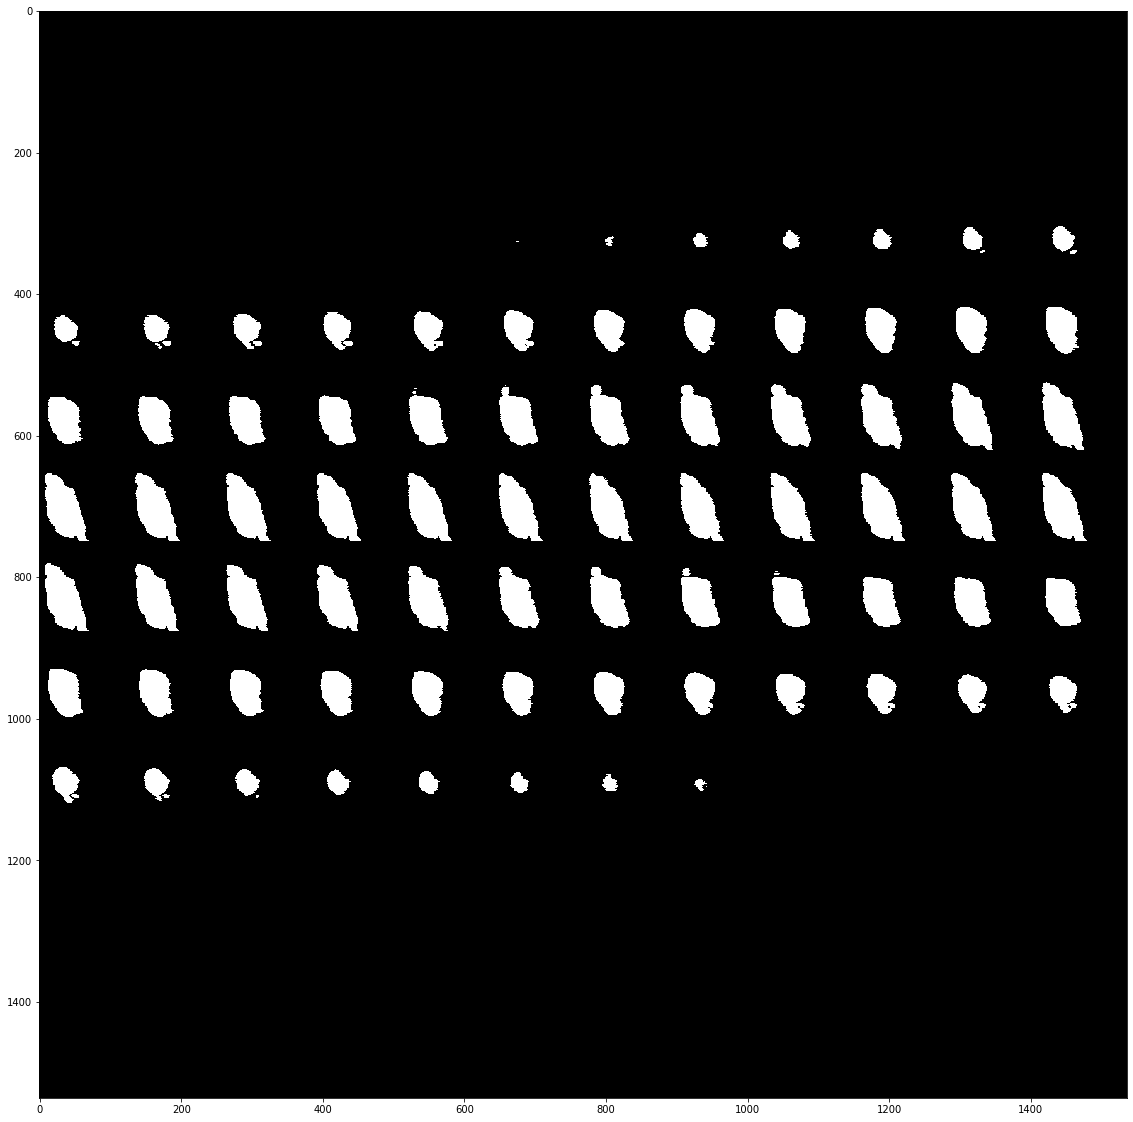

In [11]:
fig, ax1 = plt.subplots(1,1, figsize = (20, 20))
ax1.imshow(montage(test_mask), cmap ='bone')
fig.savefig('brain_mask.png')

## 3D Visulalisation

Ici on prend seulement 1 valeur sur 4 dans la direction x, y -> réduire le tableau de 4 * 4 = 16. Permute également deux fois pour une meilleure visibilité du cerveau. Puis on le maillage triangulaire résultant à l'aide de Matplotlib. 


Calculating surface...


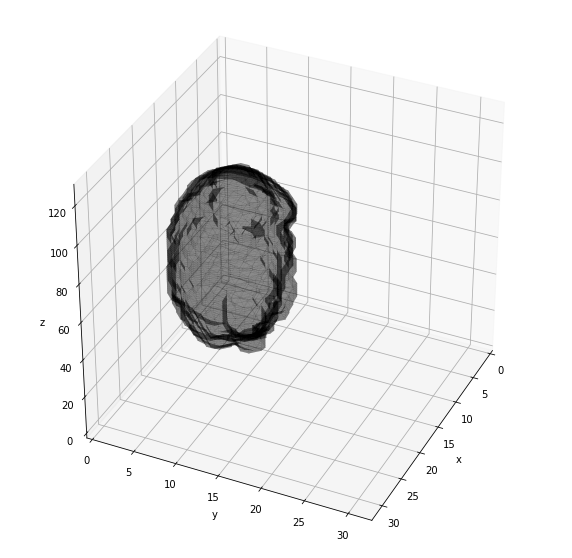

In [12]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure


p = labels[3][::1, ::4, ::4].swapaxes(1,2).swapaxes(0,2)
print ("Calculating surface...")
verts, faces, _, values = measure.marching_cubes_lewiner(p, level=0)

.fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Indexation: `verts [faces]` pour générer une collection de triangles
mesh = Poly3DCollection(list(verts[faces]), alpha=0.25, linewidth = 0.1)
edge_color = [0, 0, 0]
mesh.set_edgecolor(edge_color)
mesh.set_facecolor('k')
ax.add_collection3d(mesh)


ax.set_xlim(0, p.shape[0])
ax.set_ylim(0, p.shape[1])
ax.set_zlim(0, p.shape[2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(35, 25)
fig.savefig('brain_3d.pdf')

In [13]:
def montage_nd(in_img):
    if len(in_img.shape)>3:
        return montage2d(np.stack([montage_nd(x_slice) for x_slice in in_img],0))
    elif len(in_img.shape)==3:
        return montage2d(in_img)
    else:
        warn('Input less than 3d image, returning original', RuntimeWarning)
        return in_img

In [24]:
x_train, x_val, y_train, y_val = train_test_split(imgs, labels, test_size = 0.2)

In [29]:
x_val  = x_val.reshape((x_val.shape[0], 128,128,128,1))
x_train = x_train.reshape((x_train.shape[0], 128,128,128,1))
y_val  = y_val.reshape((y_val.shape[0], 128,128,128,1))
y_train = y_train.reshape((y_train.shape[0], 128,128,128,1))

## Data Augmentation 

Ici, nous faisons un générateur de données produisant des lots avec de petits morceaux d'images.
    L'augmentation est délicate car les images sont en 3D et nous avons des images en entrée et en sortie. Nous essayons ici une petite astuce de conversion de tranches en canaux pour faire bien fonctionner les fonctions Keras de data augmentation de Keras déjà existantes. Ainsi on modifie la classe ImageDataGenerator de Keras, afin que celle-ci puisse prendre en entrée un numpy array de taille 5


(1, 128, 128, 128, 1) (1, 128, 128, 128, 1)


/home/melmansouri/base/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/melmansouri/base/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/melmansouri/base/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/melmansouri/base/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed i

Text(0.5, 1.0, 'Out Batch')

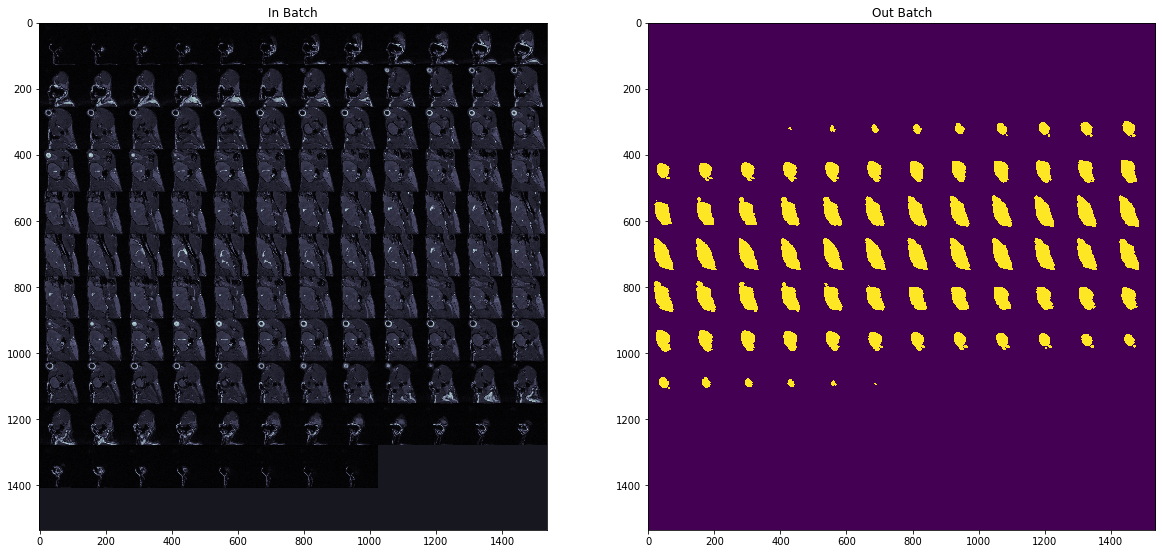

In [40]:
def gen_chunk(in_img, in_mask, slice_count = 1, batch_size = 1):
    while True:
        img_batch = []
        mask_batch = []
        for _ in range(batch_size):
            s_idx = np.random.choice(range(in_img.shape[0]-slice_count))
            img_batch += [in_img[s_idx:(s_idx+slice_count)]]
            mask_batch += [in_mask[s_idx:(s_idx+slice_count)]]
        yield np.stack(img_batch, 0).reshape((x_out.shape[0], 128,128,128,1)), np.stack(mask_batch, 0).reshape((x_out.shape[0], 128,128,128,1))

train_gen = gen_chunk(x_train, y_train)

valid_gen = gen_chunk(x_val, y_val, slice_count = 1, batch_size = 1)
x_out, y_out = next(train_gen)
print(x_out.shape, y_out.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_nd(x_out[...,0]), cmap = 'bone')
ax1.set_title('In Batch')
ax2.imshow(montage_nd(y_out[...,0]))
ax2.set_title('Out Batch')

(1, 128, 128, 128, 1) (1, 128, 128, 128, 1)


/home/melmansouri/base/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/melmansouri/base/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/melmansouri/base/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/melmansouri/base/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed i

Text(0.5, 1.0, 'Out Batch')

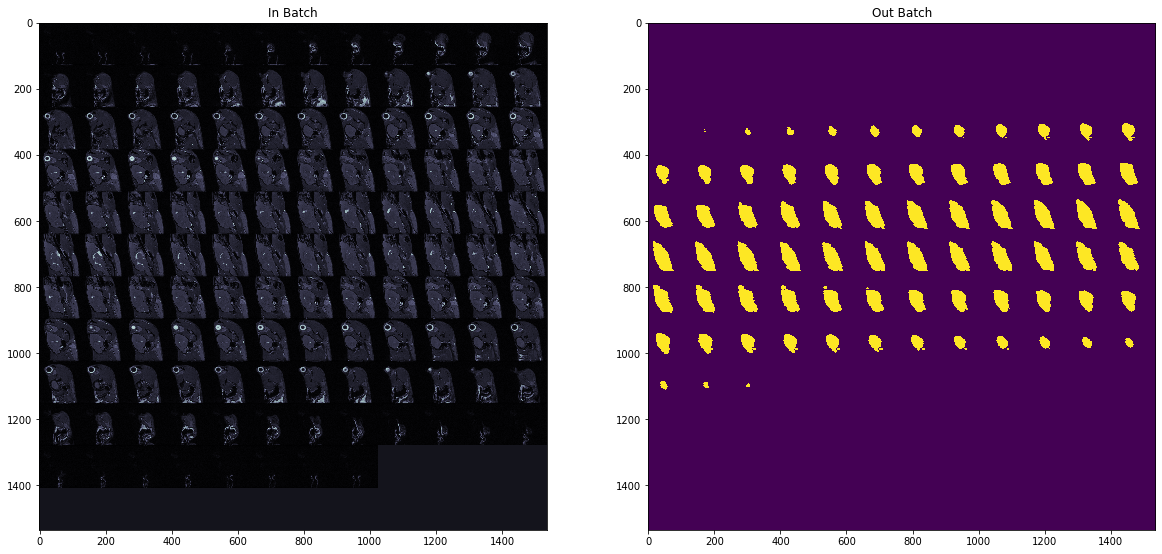

In [41]:
x_out, y_out = next(valid_gen)
print(x_out.shape, y_out.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_nd(x_out[...,0]), cmap = 'bone')
ax1.set_title('In Batch')
ax2.imshow(montage_nd(y_out[...,0]))
ax2.set_title('Out Batch')

/home/melmansouri/base/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 128, 128, 256) (256 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


(1, 128, 128, 128, 1) (1, 128, 128, 128, 1)


/home/melmansouri/base/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/melmansouri/base/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/melmansouri/base/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/melmansouri/base/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed i

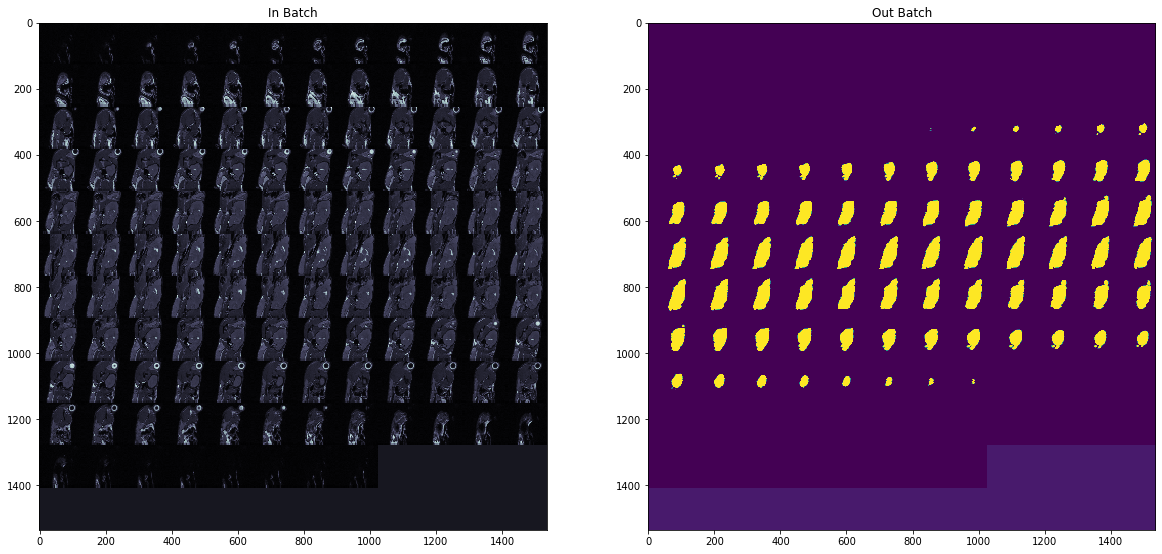

In [43]:
from keras.preprocessing.image import ImageDataGenerator
d_gen = ImageDataGenerator(rotation_range=15, 
                           width_shift_range=0.15, 
                           height_shift_range=0.15, 
                           shear_range=0.1, 
                           zoom_range=0.25, 
                           fill_mode='nearest',
                           horizontal_flip=True, 
                           vertical_flip=False)

def gen_aug_chunk(in_gen):
    for i, (x_img, y_img) in enumerate(in_gen):
        xy_block = np.concatenate([x_img, y_img], 1).swapaxes(1, 4)[:, 0]
        img_gen = d_gen.flow(xy_block, shuffle=True, seed=i, batch_size = x_img.shape[0])
        xy_scat = next(img_gen)
        # unblock
        xy_scat = np.expand_dims(xy_scat,1).swapaxes(1, 4)
        yield xy_scat[:, :xy_scat.shape[1]//2], xy_scat[:, xy_scat.shape[1]//2:]

train_aug_gen = gen_aug_chunk(train_gen)
x_out, y_out = next(train_aug_gen)
print(x_out.shape, y_out.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_nd(x_out[...,0]), cmap = 'bone')
ax1.set_title('In Batch')
ax2.imshow(montage_nd(y_out[...,0]))
ax2.set_title('Out Batch');


# Architecture UNET

L'UNET a été développé par Olaf Ronneberger et al. pour la segmentation d'images biomédicales. L'architecture contient deux chemins. Le premier chemin est le chemin de contraction (également appelé encodeur) qui est utilisé pour capturer le contexte dans l'image. L'encodeur n'est qu'une pile traditionnelle de couches de regroupement convolutionnelles et maximales. Le deuxième chemin est le chemin d'expansion symétrique (également appelé décodeur) qui est utilisé pour permettre une localisation précise en utilisant des convolutions transposées. Il s'agit donc d'un réseau entièrement convolutionnel de bout en bout (FCN), c'est-à-dire qu'il ne contient que des couches convolutionnelles et ne contient aucune couche dense à cause de laquelle il peut accepter une image de n'importe quelle taille.

![title](./d.png)


Notez que dans le papier d'origine, la taille de l'image d'entrée est de 572x572x3, cependant, nous utiliserons une image d'entrée de taille 128x128x128. Par conséquent, la taille à différents endroits sera différente de celle du papier d'origine, mais les composants principaux restent les mêmes.


In [44]:
from keras.layers import Bidirectional, BatchNormalization, Conv3D, Cropping3D, ZeroPadding3D, Activation, Input
from keras.layers import MaxPooling3D, UpSampling3D, Deconvolution3D, concatenate
from keras.models import Model

in_layer = Input((128, 128, 128,1))
bn = BatchNormalization()(in_layer)
cn1 = Conv3D(8, 
             kernel_size = (1, 5, 5), 
             padding = 'same',
             activation = 'relu')(bn)
cn2 = Conv3D(8, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(cn1)
bn2 = Activation('relu')(BatchNormalization()(cn2))

dn1 = MaxPooling3D((2, 2, 2))(bn2)
cn3 = Conv3D(16, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(dn1)
bn3 = Activation('relu')(BatchNormalization()(cn3))

dn2 = MaxPooling3D((1, 2, 2))(bn3)
cn4 = Conv3D(32, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(dn2)
bn4 = Activation('relu')(BatchNormalization()(cn4))

up1 = Deconvolution3D(16, 
                      kernel_size = (3, 3, 3),
                      strides = (1, 2, 2),
                     padding = 'same')(bn4)

cat1 = concatenate([up1, bn3])

up2 = Deconvolution3D(8, 
                      kernel_size = (3, 3, 3),
                      strides = (2, 2, 2),
                     padding = 'same')(cat1)

pre_out = concatenate([up2, bn2])

pre_out = Conv3D(1, 
             kernel_size = (3, 3, 3), 
             padding = 'same',
             activation = 'sigmoid')(pre_out)


sim_model = Model(inputs = [in_layer], outputs = [pre_out])
sim_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 128 0                                            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 128, 128, 128 4           input_5[0][0]                    
__________________________________________________________________________________________________
conv3d_6 (Conv3D)               (None, 128, 128, 128 208         batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv3d_7 (Conv3D)               (None, 128, 128, 128 1736        conv3d_6[0][0]                   
____________________________________________________________________________________________

In [33]:
x_val  = x_val.reshape((x_val.shape[0], 128,128,128,1))
x_train = x_train.reshape((x_train.shape[0], 128,128,128,1))
y_val  = y_val.reshape((y_val.shape[0], 128,128,128,1))
y_train = y_train.reshape((y_train.shape[0], 128,128,128,1))

## Entrainement du Modèle

Le modèle est compilé avec l'optimiseur Adam et nous utilisons la fonction de perte d'entropie croisée binaire car il n'y a que deux classes.

Nous utilisons les rappels Keras pour implémenter:

* Le taux d'apprentissage diminue si la perte de validation ne s'améliore pas pendant 5 époques continues.
* Early stopping si la perte de validation ne s'améliore pas pendant 10  époques continues.
* Enregistrez les poids uniquement s'il y a une amélioration de la perte de validation.

Nous utilisons des batchs de 8 pour des raisons matériels.

Notez qu'il pourrait y avoir beaucoup de possibilités pour régler ces paramètres hyper et améliorer encore les performances du modèle.




In [45]:
sim_model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['binary_accuracy', 'mse','accuracy'])
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('convlstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

W0209 20:23:28.818200 140565989988160 deprecation_wrapper.py:119] From /home/melmansouri/base/lib/python3.6/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0209 20:23:28.905933 140565989988160 deprecation.py:323] From /home/melmansouri/base/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/home/melmansouri/base/lib/python3.6/site-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [46]:

sim_model.predict(x_out).shape 

(1, 128, 128, 128, 1)

In [47]:
sim_model.fit_generator(train_aug_gen, 
                        epochs=20,
                        steps_per_epoch = 100, 
                        validation_data = valid_gen, 
                        validation_steps=10,
                       callbacks = callbacks_list)

Epoch 1/20


/home/melmansouri/base/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 128, 128, 256) (256 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


100/100 [==============================] - 744s 7s/step - loss: -0.2680 - binary_accuracy: 0.8694 - mean_squared_error: 0.1427 - acc: 0.8694 - val_loss: 1.3177 - val_binary_accuracy: 0.9208 - val_mean_squared_error: 0.3147 - val_acc: 0.9208

Epoch 00001: val_loss improved from inf to 1.31774, saving model to convlstm_model_weights.best.hdf5
Epoch 2/20
100/100 [==============================] - 632s 6s/step - loss: -0.6136 - binary_accuracy: 0.9080 - mean_squared_error: 0.0925 - acc: 0.9080 - val_loss: 0.4808 - val_binary_accuracy: 0.9128 - val_mean_squared_error: 0.2248 - val_acc: 0.9128

Epoch 00002: val_loss improved from 1.31774 to 0.48076, saving model to convlstm_model_weights.best.hdf5
Epoch 3/20
100/100 [==============================] - 634s 6s/step - loss: -0.7673 - binary_accuracy: 0.9058 - mean_squared_error: 0.0936 - acc: 0.9058 - val_loss: -0.6601 - val_binary_accuracy: 0.9173 - val_mean_squared_error: 0.1186 - val_acc: 0.9173

Epoch 00003: val_loss improved from 0.48076 t

# Analyse des résultats

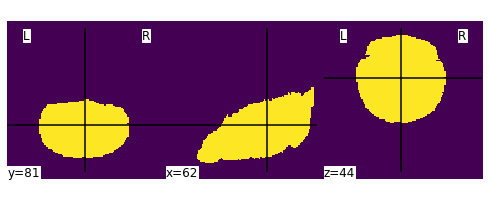

In [48]:
import nilearn.plotting as nplt 

im = nib.Nifti1Image(labels[-2], np.eye(4))
nib.save(im, "true.nii")
    
nplt.plot_img("true.nii", cut_coords=[62, 81, 44])

In [60]:
def irm(prediction):
    return np.where(prediction >= 0.5, 1, 0).astype(np.int8)


pred = irm(sim_model.predict(x_val))
pred = pred.reshape((pred.shape[0], 128,128,128))[0]

In [63]:
x_out = x_out.reshape((x_out.shape[0], 128,128,128))[0]
y_out = y_out.reshape((y_out.shape[0], 128,128,128))[0]

---------------------- The image --------------------------


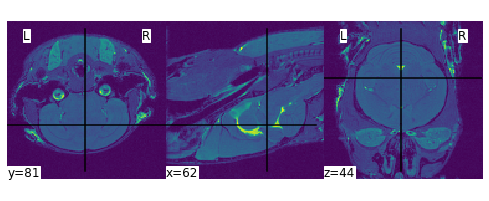

In [69]:
print('---------------------- The image --------------------------')

img = nib.Nifti1Image(x_out, np.eye(4))
nib.save(img, "img.nii")
nplt.plot_img("img.nii", cut_coords=[62, 81, 44])

---------------------- The TRUE mask --------------------------


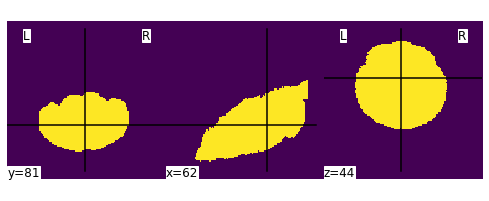

In [70]:

print('---------------------- The TRUE mask --------------------------')
img = nib.Nifti1Image(y_out, np.eye(4))
nib.save(img, "true.nii")
nplt.plot_img("true.nii", cut_coords=[62, 81, 44])



---------------------- The PREDICTED mask --------------------------


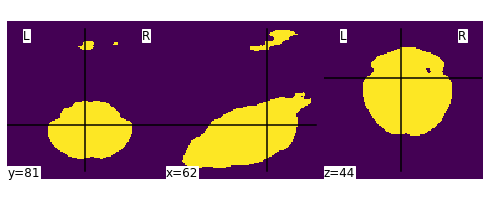

In [71]:

print('---------------------- The PREDICTED mask --------------------------')
img = nib.Nifti1Image(pred, np.eye(4))
nib.save(img, "preds.nii")
nplt.plot_img("preds.nii", cut_coords=[62, 81, 44])